<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Generacja jedno-klasowa: zdjęcie prawdziwe bądź fałszywe, bez podziału na kategorie.

Użyty został cały dataset CIFAR-10 do wygenerowania czegoś, co wygląda na prawdziwe zdjęcie.

In [44]:
'''Trains DCGAN on MNIST using Keras'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K


%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse

init = initializers.RandomNormal(stddev=0.02)

In [61]:
def plot_generated_images(inputs,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them
    For visualization purposes, generate fake images
    then plot them in a square grid
    Arguments:
        inputs: generated images
        step (int): Appended to filename of the save images
        model_name (string): Model name
    """
    plt.figure(figsize=(4, 4))
    inputs = inputs[:16]
    for i in range(0, inputs.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(((np.array(inputs[i]) + 1)* 127).astype(np.uint8))
        plt.axis('off')
    filename = os.path.join(model_name, "%05d.png" % step)
#     plt.savefig(filename)
    plt.show()

In [46]:
def build_generator(inputs):
    """Build a Generator Model
    Inputs are concatenated before Dense layer.
    Stack of BN-ReLU-Conv2DTranpose to generate fake images.
    Output activation is sigmoid instead of tanh in orig DCGAN.
    Sigmoid converges easily.
    Arguments:
        inputs (Layer): Input layer of the generator (the z-vector)
        latent_size: size of noise vector
    Returns:
        generator (Model): Generator Model
    """
    # Generator network
    generator = Sequential()

    generator.add(Dense(2*2*512, input_shape=(inputs, ), kernel_initializer=init))
    generator.add(Reshape((2, 2, 512)))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(0.2))

    generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                                  activation='tanh'))
        
    return generator

In [47]:
def build_discriminator(inputs):
    """Build a Discriminator Model
    Inputs are concatenated after Dense layer.
    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in DCGAN paper.
    Arguments:
        inputs (Layer): Input layer of the discriminator (the image)
    Returns:
        discriminator (Model): Discriminator Model
    """
    discriminator = Sequential()

    discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                             input_shape=inputs, kernel_initializer=init))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
        
    return discriminator

In [48]:
def train(models, data, params):
    """Train the Discriminator and Adversarial Networks
    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly labelled real and fake images.
    Adversarial is trained next with fake images pretending to be real.
    Discriminator inputs are conditioned by train labels for real images,
    and random labels for fake images.
    Adversarial inputs are conditioned by random labels.
    Generate sample images per save_interval.
    Arguments:
        models (list): Generator, Discriminator, Adversarial models
        data (list): x_train, y_train data
        params (list): Network parameters
    """
    # the GAN models
    generator, discriminator, adversarial = models
    # images and labels
    X_train, _ = data
    # network parameters
    batch_size, latent_size, epochs, _, model_name = params
    
    # label real and fake images
    # real images label is 1.0
    real = np.ones(shape=(batch_size, 1))
    # fake images label is 0.0
    fake = np.zeros(shape=(batch_size, 1))

    d_loss = []
    g_loss = []

    for e in range(epochs + 1):
        for i in range(len(X_train) // batch_size):

            # Train Discriminator weights
            discriminator.trainable = True

            # Real samples
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                       y=real * (0.9)) # smoothing

            # Fake Samples
            # generate fake images from noise using generator
            # generate noise using uniform distribution
            # generate fake images conditioned on fake labels
            z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_size))
            X_fake = generator.predict_on_batch(z)
            
            # train discriminator network, log the loss and accuracy
            d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)

            # Discriminator loss
            d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])

            # Train Generator weights
            discriminator.trainable = False
            # label fake images as real or 1.0
            # train the adversarial network 
            # note that unlike in discriminator training, 
            # we do not save the fake images in a variable
            # the fake images go to the discriminator input
            # of the adversarial for classification
            # log the loss and accuracy
            g_loss_batch = adversarial.train_on_batch(x=z, y=real)

            print(
                'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
                100*' ',
                end='\r'
            )

        d_loss.append(d_loss_batch)
        g_loss.append(g_loss_batch[0])
        print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

        # Plotting!
        samples = 16
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_size)))
        plot_generated_images(x_fake, e, model_name)

    # save the model after training the generator
    # the trained generator can be reloaded for 
    # future MNIST digit generation
    generator.save(model_name + ".h5")

In [53]:
def build_and_train_models():
    
    model_name = "dcgan_cifar10"
    # load CIFAR dataset
    # Preprocesing
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    # Scale for tanh
    X_train = np.float32(X_train)
    X_train = (X_train / 255 - 0.5) * 2
    X_train = np.clip(X_train, -1, 1)

    # network parameters
    # the latent or z vector is 100-dim
    latent_size = 100
    batch_size = 32
    epochs = 100
    optimizer = Adam(lr=0.0003, beta_1=0.5)
    
    # build generator model
    z = Input(shape=(latent_size,))
    generator = build_generator(latent_size)
    img = generator(z)
    
    # build discriminator model
    input_shape = (32, 32, 3)
    discriminator = build_discriminator(input_shape)
    discriminator.compile(optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
    # freeze the weights of discriminator during adversarial training
    discriminator.trainable = False
    decision = discriminator(img)

    # build adversarial model = generator + discriminator
    adversarial = Model(inputs=z, outputs=decision)
    adversarial.compile(optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

    generator.summary()
    discriminator.summary()
    adversarial.summary()

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (X_train, y_train)
    train(models, data, (batch_size, latent_size, epochs, 0, model_name))

In [54]:
def test_generator(generator, class_label=None):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    step = 0
    if class_label is None:
        num_labels = 10
        noise_class = np.eye(num_labels)[np.random.choice(num_labels, 16)]
    else:
        noise_class = np.zeros((16, 10))
        noise_class[:,class_label] = 1
        step = class_label

    plot_images(generator,
                noise_input=noise_input,
                noise_class=noise_class,
                show=True,
                step=step,
                model_name="test_outputs")

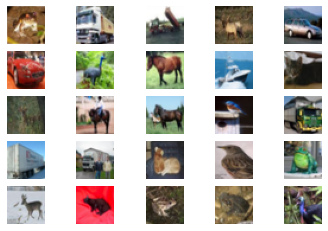

In [55]:
# Example images
# Plot example images 
(x_train, _), (_, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255

fig = plt.figure()
for i in range(5*5):
    ax = fig.add_subplot(5, 5, i+1)
    plt.imshow(x_train[i])
    plt.axis('off')

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 2048)              206848    
_________________________________________________________________
reshape_7 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_41 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 4, 4, 256)       

c:\users\virnael\appdata\local\programs\python\python36\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch = 1/100, d_loss=0.329, g_loss=1.054                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     


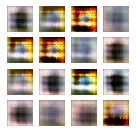

epoch = 2/100, d_loss=0.181, g_loss=0.084                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

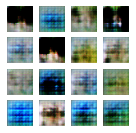

epoch = 3/100, d_loss=0.321, g_loss=0.127                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

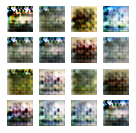

epoch = 4/100, d_loss=0.326, g_loss=11.532                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

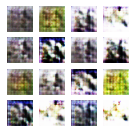

epoch = 5/100, d_loss=0.534, g_loss=6.023                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

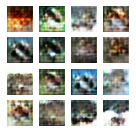

epoch = 6/100, d_loss=0.386, g_loss=3.040                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

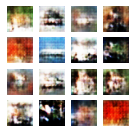

epoch = 7/100, d_loss=0.211, g_loss=2.064                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

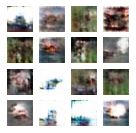

epoch = 8/100, d_loss=0.226, g_loss=4.602                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

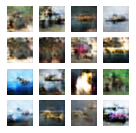

epoch = 9/100, d_loss=0.226, g_loss=4.366                                                                                                                         


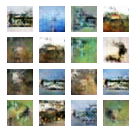

epoch = 10/100, d_loss=0.217, g_loss=3.060                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

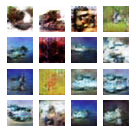

epoch = 11/100, d_loss=0.383, g_loss=3.377                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

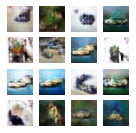

epoch = 12/100, d_loss=0.309, g_loss=2.601                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

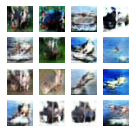

epoch = 13/100, d_loss=0.185, g_loss=4.844                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

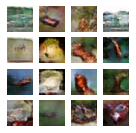

epoch = 14/100, d_loss=0.537, g_loss=2.323                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

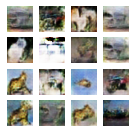

epoch = 15/100, d_loss=0.232, g_loss=3.590                                                                                                                                                                                                                                                                                                                                                                                                                                        


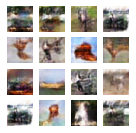

epoch = 16/100, d_loss=0.181, g_loss=6.192                                                                                                                         


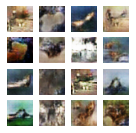

epoch = 17/100, d_loss=0.188, g_loss=4.628                                                                                                                         


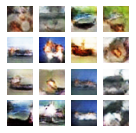

epoch = 18/100, d_loss=0.527, g_loss=1.377                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

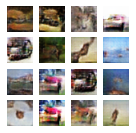

epoch = 19/100, d_loss=0.327, g_loss=2.629                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

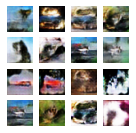

epoch = 20/100, d_loss=0.198, g_loss=4.526                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

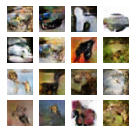

epoch = 21/100, d_loss=0.260, g_loss=3.878                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

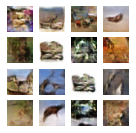

epoch = 22/100, d_loss=0.190, g_loss=5.755                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

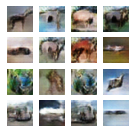

epoch = 23/100, d_loss=0.194, g_loss=4.280                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

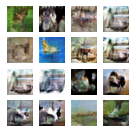

epoch = 24/100, d_loss=0.203, g_loss=4.190                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

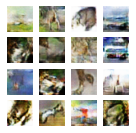

epoch = 25/100, d_loss=0.767, g_loss=7.897                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

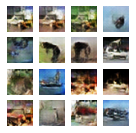

epoch = 26/100, d_loss=0.185, g_loss=5.312                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

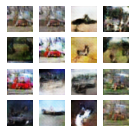

epoch = 27/100, d_loss=0.180, g_loss=7.302                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

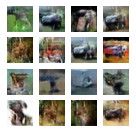

epoch = 28/100, d_loss=0.711, g_loss=4.130                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

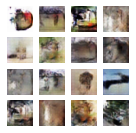

epoch = 29/100, d_loss=0.195, g_loss=6.062                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

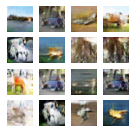

epoch = 30/100, d_loss=0.247, g_loss=4.316                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

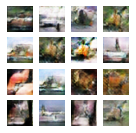

epoch = 31/100, d_loss=0.192, g_loss=6.479                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

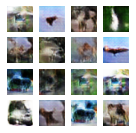

epoch = 32/100, d_loss=0.185, g_loss=5.023                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

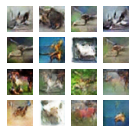

epoch = 33/100, d_loss=0.260, g_loss=4.667                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      


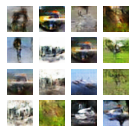

epoch = 34/100, d_loss=0.195, g_loss=4.284                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

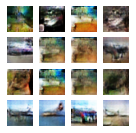

epoch = 35/100, d_loss=0.342, g_loss=3.558                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

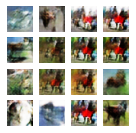

epoch = 36/100, d_loss=0.186, g_loss=5.132                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

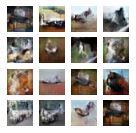

epoch = 37/100, d_loss=0.208, g_loss=6.463                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

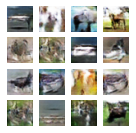

epoch = 38/100, d_loss=0.214, g_loss=5.584                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                


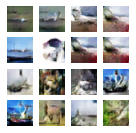

epoch = 39/100, d_loss=0.196, g_loss=9.038                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

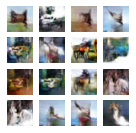

epoch = 40/100, d_loss=0.278, g_loss=4.170                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

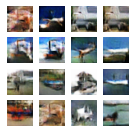

epoch = 41/100, d_loss=0.227, g_loss=5.066                                                                                                                        


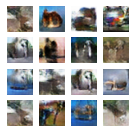

epoch = 42/100, d_loss=0.174, g_loss=7.665                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

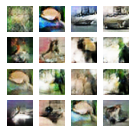

epoch = 43/100, d_loss=0.172, g_loss=8.700                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

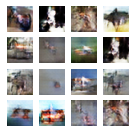

epoch = 44/100, d_loss=0.182, g_loss=5.285                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

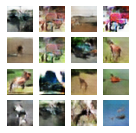

epoch = 45/100, d_loss=0.209, g_loss=7.380                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

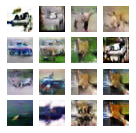

epoch = 46/100, d_loss=0.182, g_loss=7.541                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

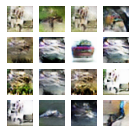

epoch = 47/100, d_loss=0.179, g_loss=5.930                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

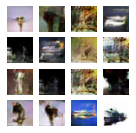

epoch = 48/100, d_loss=0.182, g_loss=4.999                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

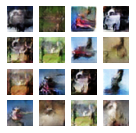

epoch = 49/100, d_loss=0.181, g_loss=6.714                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

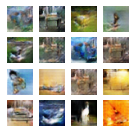

epoch = 50/100, d_loss=0.207, g_loss=3.833                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

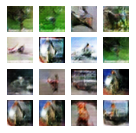

epoch = 51/100, d_loss=0.229, g_loss=4.006                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

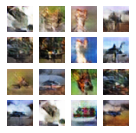

epoch = 52/100, d_loss=0.175, g_loss=6.506                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

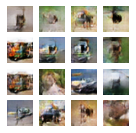

epoch = 53/100, d_loss=0.183, g_loss=4.941                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

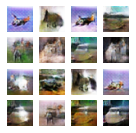

epoch = 54/100, d_loss=0.193, g_loss=6.023                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            


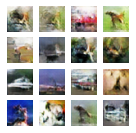

epoch = 55/100, d_loss=0.178, g_loss=6.616                                                                                                                                                                                                                             


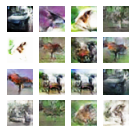

epoch = 56/100, d_loss=0.181, g_loss=7.593                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             


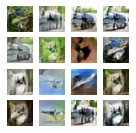

epoch = 57/100, d_loss=0.180, g_loss=5.421                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

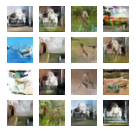

epoch = 58/100, d_loss=0.685, g_loss=3.214                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

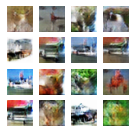

epoch = 59/100, d_loss=0.202, g_loss=5.919                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

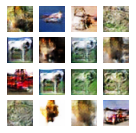

epoch = 60/100, d_loss=0.175, g_loss=5.469                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

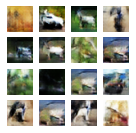

epoch = 61/100, d_loss=0.174, g_loss=5.388                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

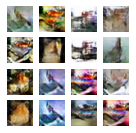

epoch = 62/100, d_loss=0.174, g_loss=3.985                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

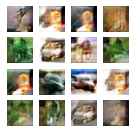

epoch = 63/100, d_loss=0.178, g_loss=4.258                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                


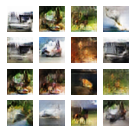

epoch = 64/100, d_loss=0.205, g_loss=7.976                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            


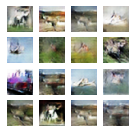

epoch = 65/100, d_loss=0.173, g_loss=6.955                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

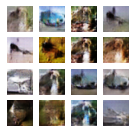

epoch = 66/100, d_loss=0.187, g_loss=7.078                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

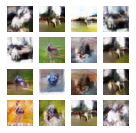

epoch = 67/100, d_loss=0.217, g_loss=4.242                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

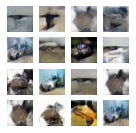

epoch = 68/100, d_loss=0.238, g_loss=3.561                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

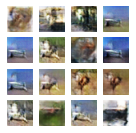

epoch = 69/100, d_loss=0.177, g_loss=5.289                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

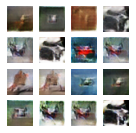

epoch = 70/100, d_loss=0.188, g_loss=5.369                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

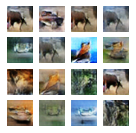

epoch = 71/100, d_loss=0.207, g_loss=3.703                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

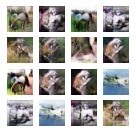

epoch = 72/100, d_loss=0.192, g_loss=5.211                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

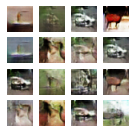

epoch = 73/100, d_loss=0.176, g_loss=4.968                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

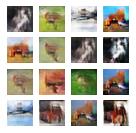

epoch = 74/100, d_loss=0.174, g_loss=4.928                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

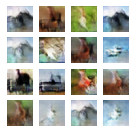

epoch = 75/100, d_loss=0.181, g_loss=4.941                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

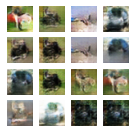

epoch = 76/100, d_loss=0.176, g_loss=4.391                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

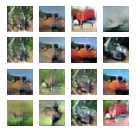

epoch = 77/100, d_loss=0.173, g_loss=7.431                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

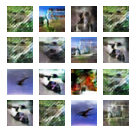

epoch = 78/100, d_loss=0.185, g_loss=4.974                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

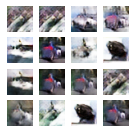

epoch = 79/100, d_loss=0.182, g_loss=4.655                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

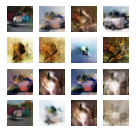

epoch = 80/100, d_loss=0.195, g_loss=5.281                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

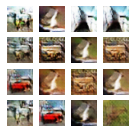

epoch = 81/100, d_loss=0.226, g_loss=5.326                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

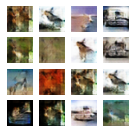

epoch = 82/100, d_loss=0.214, g_loss=4.162                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

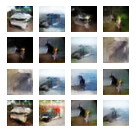

epoch = 83/100, d_loss=0.236, g_loss=4.529                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

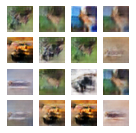

epoch = 84/100, d_loss=0.199, g_loss=4.155                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

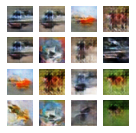

epoch = 85/100, d_loss=0.179, g_loss=4.714                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

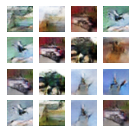

epoch = 86/100, d_loss=0.185, g_loss=4.532                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

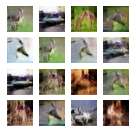

epoch = 87/100, d_loss=0.187, g_loss=5.343                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

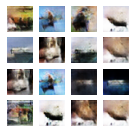

epoch = 88/100, d_loss=0.171, g_loss=5.093                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

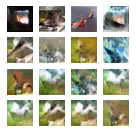

epoch = 89/100, d_loss=0.188, g_loss=3.698                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

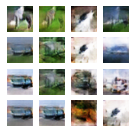

epoch = 90/100, d_loss=0.192, g_loss=4.586                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


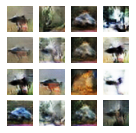

epoch = 91/100, d_loss=0.175, g_loss=3.945                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

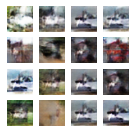

epoch = 92/100, d_loss=0.173, g_loss=6.064                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

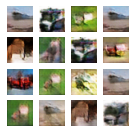

epoch = 93/100, d_loss=0.173, g_loss=6.859                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

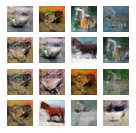

epoch = 94/100, d_loss=0.174, g_loss=4.287                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

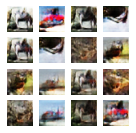

epoch = 95/100, d_loss=0.179, g_loss=4.555                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

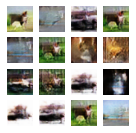

epoch = 96/100, d_loss=0.190, g_loss=4.302                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

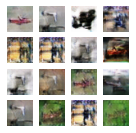

epoch = 97/100, d_loss=0.212, g_loss=5.416                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

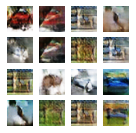

epoch = 98/100, d_loss=0.178, g_loss=6.103                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

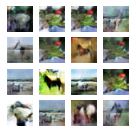

epoch = 99/100, d_loss=0.211, g_loss=4.593                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

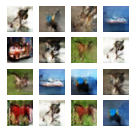

epoch = 100/100, d_loss=0.172, g_loss=5.207                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

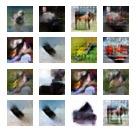

epoch = 101/100, d_loss=0.169, g_loss=6.201                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

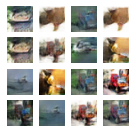

In [56]:
    parser = argparse.ArgumentParser()
    help_ = "Load generator h5 model with trained weights"
    parser.add_argument("-g", "--generator", help=help_)
    help_ = "Specify a specific digit to generate"
    parser.add_argument("-d", "--digit", type=int, help=help_)
    args = parser.parse_args()
    if args.generator:
        generator = load_model(args.generator)
        class_label = None
        if args.digit is not None:
            class_label = args.digit
        test_generator(generator, class_label)
    else:


# build_and_train_models()

Naturalnie GAN nie może się zdecydować jaką klasę generować, więc generacja jest przypadkowa (zależna od szumu na wejściu).

Dodatkowo, wygląda na to, że 100 epok nie było wymagane i algorytm już dużo wcześniej zdążył się nauczyć generacji obiektów wyglądających jak prawdziwe.

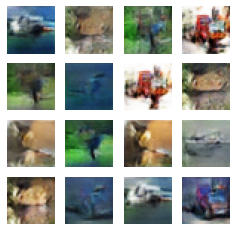

In [81]:
latent_size = 100
gen = build_generator(latent_size)
model_name = "dcgan_cifar10.h5"
gen.load_weights(model_name)

samples = 16
x_fake = gen.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_size)))
plot_generated_images(x_fake, -1, model_name)